# Tallinn and Helsinky. How similar or dissimilar they are?

["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804)

https://ogre.adc4gis.com/


Source: [District Map of the City of Helsinki](https://hri.fi/data/en_GB/dataset/helsingin-kaupunginosat).  The maintainer of the dataset is Helsingin kaupunkiympäristön toimiala / Kaupunkimittauspalvelut. The dataset has been downloaded from [Helsinki Region Infoshare](https://hri.fi/) service on 22.11.2019 under the license [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/).

https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json

### Install packages and load libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle json

In [2]:
#!conda install -c conda-forge geopy --yes 

In [3]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# transform geo coordinates
from pyproj import Proj, transform

In [4]:
#!conda config --set ssl_verify false 
#!conda install -c conda-forge folium=0.5.0 --yes

In [5]:
import folium # plotting library
print(folium.__version__)

0.5.0


## Tallinn

Let's load geo data and create map with district boundaries and pandas dataframe with district names and coordiantes.

To load geo data I use ["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804) resource to download shape files for boundaries and then with [ogre web site](https://ogre.adc4gis.com/) covert it to geojson format.
> NB! Because of shape file contains coordiantes in Estonian Coordinate System (EPSG:3301) use appropriate options to covert coordinates in World Geodetic System (EPSG:4326)
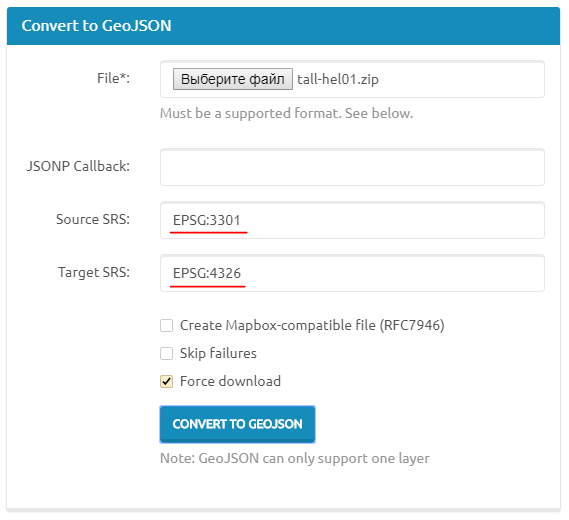
  
As a result I get json file renamed to *tallinn_geo_converted.json*.  
To create dataframe I walk through this file getting district name and using geopy library to define coordinates. First, let's create function for getting coordinates by address:

In [50]:
def coordinates(geolocator, district_name, address_pattern):
    address = address_pattern.format(district_name)
    location = geolocator.geocode(address, timeout=20)
    latitude = location.latitude
    longitude = location.longitude
        
    return location.latitude, location.longitude

In [48]:
# define Tallinn coordiantes
address = 'Tallinn, Etonia'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address, timeout=10)
tallinn_latitude = location.latitude
tallinn_longitude = location.longitude
print(tallinn_latitude, tallinn_longitude)

59.4372155 24.7453688


Done. It's time for dataframe:

In [59]:
with open('tallinn_geo_converted.json', encoding='utf-8') as json_data:
    tallinn_data = json.load(json_data)

tallinn_districts = []
features = tallinn_data['features']
for feature in features:
    properties = feature['properties']
    latitude, longitude  = coordinates(geolocator, 
                                       district_name='{},{}'.format(properties['asumi_nimi'], properties['linnaosa_n']),
                                       address_pattern='{}, Tallinn, Estonia')
    tallinn_districts.append([properties['linna_nimi'],properties['linnaosa_n'],properties['asumi_nimi'], latitude, longitude])
tallinn_districts[0:5]

[['Tallinna linn', 'Kesklinna linnaosa', 'Raua', 59.4364562, 24.768514],
 ['Tallinna linn', 'Pirita linnaosa', 'Iru', 59.4616235, 24.9044609],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Seli', 59.4442151, 24.893329],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Sõjamäe', 59.4245821, 24.8434934],
 ['Tallinna linn', 'Nõmme linnaosa', 'Kivimäe', 59.3780192, 24.6559073]]

In [60]:
df_tallinn = pd.DataFrame(tallinn_districts, columns=['City','Borough','Neighborhood', 'Latitude', 'Longitude'])
df_tallinn.head(10)

City                  Borough Neighborhood   Latitude  Longitude
0  Tallinna linn       Kesklinna linnaosa         Raua  59.436456  24.768514
1  Tallinna linn          Pirita linnaosa          Iru  59.461624  24.904461
2  Tallinna linn        Lasnamäe linnaosa         Seli  59.444215  24.893329
3  Tallinna linn        Lasnamäe linnaosa      Sõjamäe  59.424582  24.843493
4  Tallinna linn           Nõmme linnaosa      Kivimäe  59.378019  24.655907
5  Tallinna linn        Lasnamäe linnaosa    Kuristiku  59.451492  24.866185
6  Tallinna linn  Põhja-Tallinna linnaosa   Pelguranna  59.454976  24.688860
7  Tallinna linn           Nõmme linnaosa         Hiiu  59.383453  24.671893
8  Tallinna linn  Põhja-Tallinna linnaosa    Merimetsa  59.434183  24.695458
9  Tallinna linn       Kesklinna linnaosa     Kompassi  59.435810  24.760920

In [87]:
df_tallinn.describe(include='all')

City             Borough Neighborhood   Latitude  Longitude
count              84                  84           84  84.000000  84.000000
unique              1                   8           84        NaN        NaN
top     Tallinna linn  Kesklinna linnaosa         Seli        NaN        NaN
freq               84                  21            1        NaN        NaN
mean              NaN                 NaN          NaN  59.431217  24.749062
std               NaN                 NaN          NaN   0.031762   0.083144
min               NaN                 NaN          NaN  59.354481  24.570101
25%               NaN                 NaN          NaN  59.413300  24.688378
50%               NaN                 NaN          NaN  59.432154  24.746623
75%               NaN                 NaN          NaN  59.446211  24.812205
max               NaN                 NaN          NaN  59.581319  24.904461

In [91]:
df_tallinn.to_csv('tallinn_heighborhoods.csv', encoding='utf-8')

In [61]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
#tallinn_markers = folium.map.FeatureGroup()
# add markers to map
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

Let's correct some coordinates:

Pirita - 59.468293, 24.834434
Mähe - 59.482542, 24.852122
Tondiraba - 59.442126, 24.859120
Pae - 59.435165, 24.822060
Uuslinn - 59.437080, 24.803290
Juhkentali - 59.425090, 24.769411
Veerenni - 59.424482, 24.749281
Kitseküla - 59.414870, 24.739392
Tondi - 59.408026, 24.724908
Lilleküla - 59.419546, 24.712606
Siili - 59.406715, 24.706119
Sääse - 59.409706, 24.695449
Pelguranna - 59.447834, 24.692225
Mustjõe - 59.428602, 24.680109
Veskimetsa - 59.420996, 24.660690
Liiva - 59.382957, 24.731037
Laagri - 59.355412, 24.619176
Vana-Mustamäe - 59.390358, 24.645816
Astangu - 59.402235, 24.627247
Kopli - 59.459025, 24.673429
Nõmme - 59.379267, 24.694357
Väo - 59.435219, 24.897147
Haabersti - 59.427789, 24.643465
Pikaliiva - 

In [102]:
df_tallinn = pd.read_csv('tallinn_heighborhoods.csv', encoding='utf-8')
df_tallinn.head(10)

Unnamed: 0           City                  Borough Neighborhood   Latitude  \
0           0  Tallinna linn       Kesklinna linnaosa         Raua  59.436456   
1           1  Tallinna linn          Pirita linnaosa          Iru  59.461624   
2           2  Tallinna linn        Lasnamäe linnaosa         Seli  59.444215   
3           3  Tallinna linn        Lasnamäe linnaosa      Sõjamäe  59.424582   
4           4  Tallinna linn           Nõmme linnaosa      Kivimäe  59.378019   
5           5  Tallinna linn        Lasnamäe linnaosa    Kuristiku  59.451492   
6           6  Tallinna linn  Põhja-Tallinna linnaosa   Pelguranna  59.447834   
7           7  Tallinna linn           Nõmme linnaosa         Hiiu  59.383453   
8           8  Tallinna linn  Põhja-Tallinna linnaosa    Merimetsa  59.434183   
9           9  Tallinna linn       Kesklinna linnaosa     Kompassi  59.435810   

   Longitude  
0  24.768514  
1  24.904461  
2  24.893329  
3  24.843493  
4  24.655907  
5  24.866185  
6  24.692225  
7  24.671893  
8  24.695458  
9  24.760920

In [103]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
#tallinn_markers = folium.map.FeatureGroup()
# add markers to map
def style_function(feature):
    return {
        'color' : '#2222FF',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

### Define Foursquare Credentials and Version

##### Make sure that you have created a Foursquare developer account and have your credentials handy

In [44]:
# hidden_cell
CLIENT_ID = 'WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR' # your Foursquare ID
CLIENT_SECRET = '2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK' # your Foursquare Secret
VERSION = '20191118'
LIMIT = 100
RADIUS = 500

Your credentails:
CLIENT_ID: WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR
CLIENT_SECRET:2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK


In [8]:
address = 'Tallinn, Etonia'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

59.4372155 24.7453688


In [9]:
tallin_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Tallinn
'''
tallin_map.choropleth(geo_data='tallin01.json',
                      key_on='Feature.properties.asumi_nimi',
                      fill_color='YlOrRd', 
                      fill_opacity=0.7,
                      line_opacity=0.2,)
'''
#folium.GeoJson('t02_41_asum.json', style_function=style_function).add_to(tallin_map)
tallin_map

In [36]:
#!conda install -c conda-forge pyproj --yes 

In [72]:
with open('tallin03.json', encoding='utf-8') as json_data:
    tallinn_data = json.load(json_data)

In [73]:
inProj = Proj(init='epsg:3301') # ee
outProj = Proj(init='epsg:4326') # WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS
#spb = [x for x in features if 'Petersburg' in x['properties']['NAME_1']]
#spb[0]['properties']
features = tallinn_data['features']
features[0]
for feature in features:
    geometry = feature['geometry']
    print(geometry['type'], np.shape(geometry['coordinates']))
    Polygons = []
    if geometry['type'] == 'MultiPolygon' :
        Polygons = geometry['coordinates']
    else:
        Polygons.append(geometry['coordinates'])

    for polygon in Polygons:
        points = polygon[0]
        for point in points:
#            x1,y1 = point[0],point[1]
            point[0],point[1] = transform(inProj,outProj,point[0],point[1])

            
#        print('--', np.shape(points))


Polygon (1, 7, 2)
Polygon (1, 28, 2)
Polygon (1, 14, 2)
Polygon (1, 36, 2)
Polygon (1, 33, 2)
Polygon (1, 17, 2)
Polygon (1, 16, 2)
Polygon (1, 40, 2)
Polygon (1, 19, 2)
Polygon (1, 10, 2)
Polygon (1, 31, 2)
Polygon (1, 19, 2)
Polygon (1, 8, 2)
Polygon (1, 28, 2)
Polygon (1, 13, 2)
Polygon (1, 19, 2)
Polygon (1, 10, 2)
Polygon (1, 52, 2)
Polygon (1, 56, 2)
Polygon (1, 26, 2)
Polygon (1, 65, 2)
Polygon (1, 12, 2)
Polygon (1, 24, 2)
Polygon (1, 29, 2)
Polygon (1, 9, 2)
Polygon (1, 17, 2)
Polygon (1, 20, 2)
Polygon (1, 33, 2)
Polygon (1, 24, 2)
Polygon (1, 13, 2)
Polygon (1, 41, 2)
Polygon (1, 16, 2)
Polygon (1, 6, 2)
Polygon (1, 12, 2)
Polygon (1, 13, 2)
Polygon (1, 11, 2)
Polygon (1, 14, 2)
Polygon (1, 26, 2)
Polygon (1, 37, 2)
Polygon (1, 37, 2)
Polygon (1, 18, 2)
Polygon (1, 12, 2)
Polygon (1, 20, 2)
Polygon (1, 9, 2)
Polygon (1, 9, 2)
Polygon (1, 28, 2)
Polygon (1, 16, 2)
Polygon (1, 16, 2)
Polygon (1, 31, 2)
Polygon (1, 55, 2)
Polygon (1, 15, 2)
Polygon (1, 12, 2)
Polygon (1, 40, 2)

In [74]:
with open("tallin_geo01.json", "w", encoding='utf-8') as write_file:
    json.dump(tallinn_data, write_file, ensure_ascii=False)

In [19]:
def style_function(feature):
    return {
        'color' : '#00FF00',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#0000FF' 
    }

tallin_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around the Tallinn
folium.GeoJson('tallin_geo01.json', style_function=style_function).add_to(tallin_map)
tallin_map

In [11]:
address = 'Helsinki, Finland'

location = geolocator.geocode(address)
h_latitude = location.latitude
h_longitude = location.longitude
print(h_latitude, h_longitude)

60.1674086 24.9425683


In [13]:
helsinki_map = folium.Map(location=[h_latitude, h_longitude], zoom_start=12) # generate map centred around the Helsinki
helsinki_map

In [14]:
with open('helsinki.json', encoding='utf-8') as json_data:
    helsinki_data = json.load(json_data)

inProj = Proj(init='epsg:3879') # fi
outProj = Proj(init='epsg:4326')
#spb = [x for x in features if 'Petersburg' in x['properties']['NAME_1']]
#spb[0]['properties']
features = helsinki_data['features']
features[0]
for feature in features:
    geometry = feature['geometry']
    print(geometry['type'], np.shape(geometry['coordinates']))
    Polygons = []
    if geometry['type'] == 'MultiPolygon' :
        Polygons = geometry['coordinates']
    else:
        Polygons.append(geometry['coordinates'])

    for polygon in Polygons:
        points = polygon[0]
        for point in points:
#            x1,y1 = point[0],point[1]
            point[0],point[1] = transform(inProj,outProj,point[0],point[1])

            
#        print('--', np.shape(points))
with open("helsinki_geo01.json", "w", encoding='utf-8') as write_file:
    json.dump(helsinki_data, write_file, ensure_ascii=False)

Polygon (1, 99, 2)
Polygon (1, 123, 2)
Polygon (1, 122, 2)
Polygon (1, 1492, 2)
Polygon (1, 138, 2)
Polygon (1, 83, 2)
Polygon (1, 322, 2)
Polygon (1, 10, 2)
Polygon (1, 126, 2)
Polygon (1, 287, 2)
Polygon (1, 218, 2)
Polygon (1, 443, 2)
Polygon (1, 593, 2)
Polygon (1, 219, 2)
Polygon (1, 491, 2)
Polygon (1, 28, 2)
Polygon (1, 219, 2)
Polygon (1, 819, 2)
Polygon (1, 343, 2)
Polygon (1, 76, 2)
Polygon (1, 87, 2)
Polygon (1, 16, 2)
Polygon (1, 140, 2)
Polygon (1, 19, 2)
Polygon (1, 359, 2)
Polygon (1, 39, 2)
Polygon (1, 173, 2)
Polygon (1, 281, 2)
Polygon (1, 103, 2)
Polygon (1, 35, 2)
Polygon (1, 223, 2)
Polygon (1, 97, 2)
Polygon (1, 147, 2)
Polygon (1, 21, 2)
Polygon (1, 121, 2)
Polygon (1, 65, 2)
Polygon (1, 58, 2)
Polygon (1, 35, 2)
Polygon (1, 958, 2)
Polygon (1, 29, 2)
Polygon (1, 85, 2)
Polygon (1, 39, 2)
Polygon (1, 20, 2)
Polygon (1, 312, 2)
Polygon (1, 114, 2)
Polygon (1, 364, 2)
Polygon (1, 51, 2)
Polygon (1, 214, 2)
Polygon (1, 99, 2)
Polygon (1, 280, 2)
Polygon (1, 634, 2)


In [21]:
helsinki_map = folium.Map(location=[h_latitude, h_longitude], zoom_start=11) # generate map centred around the Helsinki
folium.GeoJson('helsinki_geo01.json', style_function=style_function).add_to(helsinki_map)
helsinki_map

In [34]:
address = 'KONALA, Helsinki, Finland'

location = geolocator.geocode(address)
r_latitude = location.latitude
r_longitude = location.longitude
print(r_latitude, r_longitude)

60.2385504 24.8460646


In [40]:
helsinki_map = folium.Map(location=[h_latitude, h_longitude], zoom_start=11) # generate map centred around the Helsinki
markers = folium.map.FeatureGroup()

with open('helsinki_geo01.json', encoding='utf-8') as json_data:
    helsinki_data = json.load(json_data)

features = helsinki_data['features']
for feature in features:
    properties = feature['properties']
    address = '{}, Helsinki, Finland'.format(properties['nimi_fi'])
    location = geolocator.geocode(address, timeout=10)
    r_latitude = location.latitude
    r_longitude = location.longitude
    print(properties['nimi_fi'], '[{},{}]'.format(r_latitude, r_longitude))
    markers.add_child(
        folium.features.CircleMarker(
            [r_latitude, r_longitude],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    folium.Marker(
        location=[r_latitude, r_longitude],
        icon=None,
        popup=properties['nimi_fi'],
    ).add_to(markers)

MEILAHTI [60.1913479,24.9026643]
HERTTONIEMI [60.1955246,25.0290632]
SÖRNÄINEN [60.1838848,24.9644087]
ÖSTERSUNDOM [60.25960365,25.1870084785404]
HERMANNI [60.1966243,24.9709346]
MUNKKINIEMI [60.1990937,24.8743585]
VALLILA [60.1961671,24.9567103]
ALUEMERI [59.9992928,25.020177966644]
ULLANLINNA [60.1587146,24.949404]
KARHUSAARI [60.1723955,25.1179524056572]
RUSKEASUO [60.2048026,24.9056207]
PAKILA [60.243545,24.9399631]
MELLUNKYLÄ [60.23596475,25.0892178510239]
VANHAKAUPUNKI [60.2141157,24.9791849]
TUOMARINKYLÄ [60.2572811,24.9680161]
KULOSAARI [60.1853879,25.0096847]
KUMPULA [60.2040009,24.9581075]
SALMENKALLIO [60.244024,25.1574065]
KAARELA [60.25193055,24.8730778298512]
KAARTINKAUPUNKI [60.1652138,24.9472225]
LÄNSISATAMA [60.1595545,24.9146468240679]
SUOMENLINNA [60.1457064,24.9888603]
ALPPIHARJU [60.189728,24.9441203]
KATAJANOKKA [60.1669752,24.9681511]
PITÄJÄNMÄKI [60.222711,24.8643556]
LAUTTASAARI [60.1593692,24.8753044]
PUKINMÄKI [60.245247,24.9896936]
ULTUNA [60.2713667,25.2021

In [41]:
folium.GeoJson('helsinki_geo01.json', style_function=style_function).add_to(helsinki_map)
helsinki_map.add_child(markers)

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
import geocoder

In [86]:
g = geocoder.google('Kloostrimetsa, Tallinn, Estonia')
lat_lng_coords = g.latlng
print(lat_lng_coords[0], lat_lng_coords[1])

TypeError: 'NoneType' object is not subscriptable